In [1]:
import keras

import pandas as pd
from pandas.plotting import lag_plot

import scipy.stats
import pylab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense # final output layer
from keras.layers import LSTM
from keras.models import load_model
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
C:\Users\LES\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
gold = pd.read_csv('../data/gold_clean.csv',parse_dates=['Date'], index_col='Date')
gold.index.freq='MS'

In [3]:
gold.index

DatetimeIndex(['1971-01-01', '1971-02-01', '1971-03-01', '1971-04-01',
               '1971-05-01', '1971-06-01', '1971-07-01', '1971-08-01',
               '1971-09-01', '1971-10-01',
               ...
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', name='Date', length=592, freq='MS')

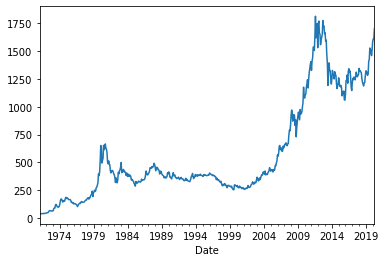

In [4]:
gold.spot_gold.plot()

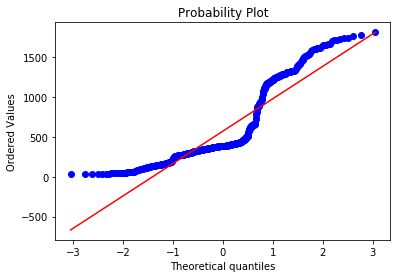

In [5]:
scipy.stats.probplot(gold.spot_gold, plot = pylab)
pylab.show()

In [6]:
train = gold[:580]
test = gold[580:]

### Data Scaling

In [7]:
scaler = MinMaxScaler()

# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [8]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator
This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

In [9]:
length = 12 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [10]:
n_features = 1
n_input = 12

model = Sequential()
model.add(LSTM(200,activation='relu', 
               input_shape=(length,n_features))) 
# '200' input to LSTM is more of a trail and error and it depends on ur data
model.add(Dense(1)) # aggregates all neutrons into a single output
model.compile(optimizer='adam',loss='mse')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit_generator(train_generator,epochs=25)

Epoch 1/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0070
Epoch 2/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0019
Epoch 3/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0016
Epoch 4/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0015
Epoch 5/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 6/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 7/25
568/568 [==============================] - 3s 5ms/step - loss: 9.0337e-04
Epoch 8/25
568/568 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 9/25
568/568 [==============================] - 3s 5ms/step - loss: 9.1639e-04
Epoch 10/25
568/568 [==============================] - 3s 5ms/step - loss: 7.9522e-04
Epoch 11/25
568/568 [==============================] - 3s 5ms/step - loss: 8.4516e-04
Epoch 12/25
568/568 [==============================] - 3s 5ms/step - loss: 7.3023e-04
Epoch

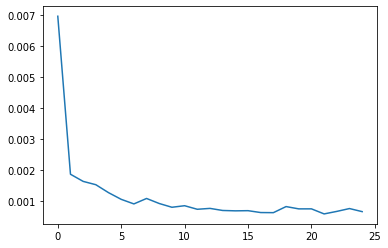

In [13]:
loss1 = model.history.history['loss']
plt.plot(range(len(loss1)),loss1)

In [14]:
### Forecast using RNN model

In [15]:
# placeholder for predictions
test_prediction = []

# last n_inputs from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants(same format as TimGenerator)
current_batch = first_eval_batch.reshape((1,n_input,n_features))


# can fcast for longer period by changing range(len(test))
# But if too long into future, it can be fcasting on fcasted data which will result in noisy predictions
# fcast for the test preiod only
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0] # one time step ahead of historical 12 pts
    test_prediction.append(current_pred)
    
# current_batch.ndim = 3 . example array([[[0.63432772]...[0.5584238 ]]]), notice the 3 levels of brackets. Deep!
# np.append adds the 'current_pred' into current_batch at middle array by specifying posn using 'axis=1'
# current_batch.shape is 1,12,1
# current_batch[:,1:,:], first and 3rd colon means all
# current_batch[:,1:,:].shape is 1,11,1
# shifts the array forward by 1 'current_batch[:,1:,:]'
# updates 'current_pred' by inserting it at the top/first/front value of the current_batch  
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [16]:
true_predictions = scaler.inverse_transform(test_prediction)

In [17]:
test['Predictions'] = true_predictions

C:\Users\LES\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


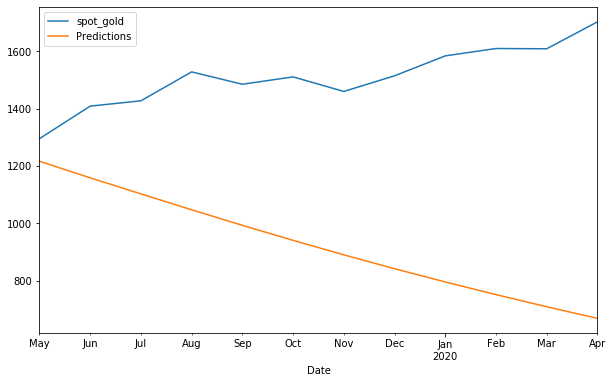

In [18]:
test.plot(figsize=(10,6))

In [19]:
error_may18_to_apr20 = rmse(test['spot_gold'],test['Predictions'])
print(f'Train model RMSE for past 2 years: {error_may18_to_apr20}')

Train model RMSE for past 2 years: 644.3560070727465


### Model with full data

Predict next 8 months

In [20]:
scaler = MinMaxScaler()

# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(gold)

MinMaxScaler()

In [21]:
scaled_gold = scaler.transform(gold)

In [22]:
length = 8 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
gold_generator = TimeseriesGenerator(scaled_gold, scaled_gold, length=length, batch_size=batch_size)

In [23]:
n_features = 1
n_input = 8

model1 = Sequential()
model1.add(LSTM(200,activation='relu', 
               input_shape=(length,n_features))) 
# '200' input to LSTM is more of a trail and error and it depends on ur data
model1.add(Dense(1)) # aggregates all neutrons into a single output
model1.compile(optimizer='adam',loss='mse')

In [24]:
model1.fit_generator(gold_generator,epochs=30)

Epoch 1/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0077
Epoch 2/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 3/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0017
Epoch 4/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 5/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 6/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 7/30
584/584 [==============================] - 2s 4ms/step - loss: 9.6774e-04
Epoch 8/30
584/584 [==============================] - 2s 4ms/step - loss: 9.9989e-04
Epoch 9/30
584/584 [==============================] - 2s 4ms/step - loss: 7.6988e-04
Epoch 10/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 11/30
584/584 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 12/30
584/584 [==============================] - 2s 4ms/step - loss: 7.7000e-04
Epoch 13/

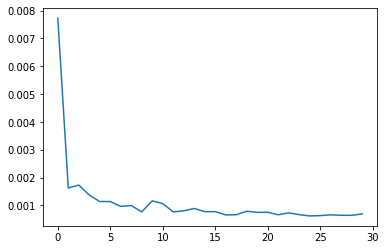

In [25]:
loss1 = model1.history.history['loss']
plt.plot(range(len(loss1)),loss1)

In [26]:
test_prediction1 = []

# last n_inputs from the training set
first_eval_batch1 = scaled_gold[-n_input:]
# reshape this to the format RNN wants(same format as TimGenerator)
current_batch1 = first_eval_batch1.reshape((1,n_input,n_features))


# can fcast for longer period by changing range(len(test))
# But if too long into future, it can be fcasting on fcasted data which will result in noisy predictions
# fcast for the test preiod only
for i in range(8):
    current_pred1 = model1.predict(current_batch1)[0] # one time step ahead of historical 12 pts
    test_prediction1.append(current_pred1)
    
# current_batch.ndim = 3 . example array([[[0.63432772]...[0.5584238 ]]]), notice the 3 levels of brackets. Deep!
# np.append adds the 'current_pred' into current_batch at middle array by specifying posn using 'axis=1'
# current_batch.shape is 1,12,1
# current_batch[:,1:,:], first and 3rd colon means all
# current_batch[:,1:,:].shape is 1,11,1
# shifts the array forward by 1 'current_batch[:,1:,:]'
# updates 'current_pred' by inserting it at the top/first/front value of the current_batch  
    
    current_batch1 = np.append(current_batch1[:,1:,:],[[current_pred1]],axis=1)

In [27]:
true_predictions1 = scaler.inverse_transform(test_prediction1)

In [28]:
len(test_prediction1)

8

In [29]:
date_list = pd.date_range('2020-05-01','2020-12-01', 
              freq='MS').strftime("%Y-%m-%d").tolist()

In [30]:
df1 = pd.DataFrame({
    'Date':date_list})

In [31]:
df1.head(20)

,Date
0,2020-05-01
1,2020-06-01
2,2020-07-01
3,2020-08-01
4,2020-09-01
5,2020-10-01
6,2020-11-01
7,2020-12-01


In [32]:
gold.head()

,spot_gold
Date,
1971-01-01,38.05
1971-02-01,38.80
1971-03-01,38.88
1971-04-01,39.70
1971-05-01,40.84


In [33]:
df1['spot_gold'] = true_predictions1

In [34]:
df1['Date']= pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
df1.index.freq='MS'

In [35]:
gold1 = pd.concat([gold,df1])

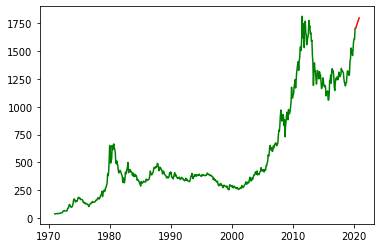

In [36]:
plt.plot(gold['spot_gold'],'g')
plt.plot(df1['spot_gold'],'r')